In [1]:
# add to path to acces cli 
import sys
import os
import time
import math
import tqdm
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from typing import Optional
from scipy import signal

sys.path.insert(0, os.path.abspath("../cli"))
print(sys.path)
plt.rcParams['figure.figsize'] = (10, 10)  # Increases figure size
from simulation.sonar import Sonar_v2
from simulation.utils import FlatBottom, EllipsisBottom
from simulation.sources import SineSource, MultiFrequencySource

from devito import Operator
from examples.seismic import Receiver, plot_velocity

['/home/hajta2/study/sonar-FWI/cli', '/home/hajta2/study/sonar-FWI/notebooks', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/hajta2/.local/lib/python3.10/site-packages', '/usr/lib/python3.10/site-packages']


Setting up parameters of the simulation

In [2]:
domain_size = (60, 30)  # (m, m)
f0 = 5.0  # kHz
v_env = 1.5  # km/s
ns = 128
source_distance = 0.02  # m
center_pos_rel = (0.5, 0.0)
max_distance = math.sqrt((domain_size[0] / 2) ** 2 + domain_size[1] ** 2)
t_end = max_distance * 2 / v_env + 5

51it [00:00, 2265.32it/s]
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


Signal packet duration: 1.6064999625086784 ms


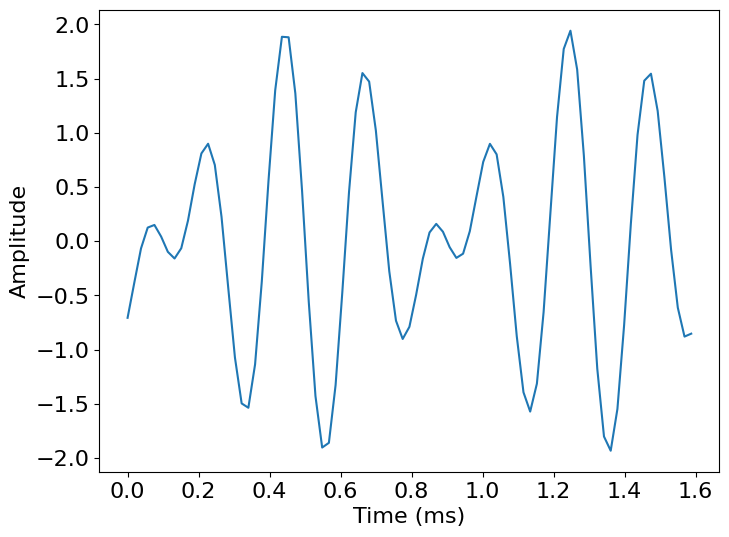

Operator `Kernel` ran in 0.54 s


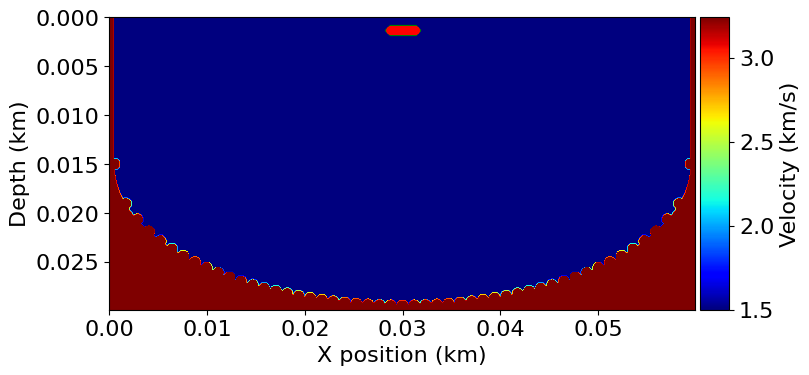

In [3]:
sonar = Sonar_v2(domain_size, f0, v_env, EllipsisBottom(domain_size[0], domain_size[1], True), t_end)
sonar.set_source(source_distance = source_distance, ns = ns)
sonar.finalize(snapshot_delay=0.1)
packet = sonar.src.signal_packet
plt.plot(sonar.time_range.time_values[:packet.shape[0]], packet)
print(f"Signal packet duration: {packet.shape[0] * sonar.time_range.step} ms")
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()
assert isinstance(sonar.op, Operator) and isinstance(sonar.rec, Receiver)
sonar.op(time=sonar.time_range.num - 2, dt=sonar.model.critical_dt)
plot_velocity(sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data)

In [4]:
def run_beam(src, rec, op, u, source_distance, time_range, dt, alpha, v_env):
    ns = src.coordinates.data.shape[0]
    max_latency = np.cos(np.deg2rad(alpha)) * (ns * source_distance / v_env) / dt
    max_latency = int(max_latency) if max_latency > 0 else 0
    for i in range(ns):
        latency = -np.cos(np.deg2rad(alpha)) * (i * source_distance / v_env)
        src.data[:, i] = np.roll(src.data[:, i], int(latency / dt + max_latency))
    u.data.fill(0)
    op(time=time_range.num - 2, dt=dt)
    return rec.data, max_latency

def object_distance(step, dt, v_env):
    return step * dt * v_env / 2

def num_steps(distance, dt, v_env):
    return distance / (dt * v_env)

def detect_echo_after(
    recording,
    timestep: float,
    signal: npt.NDArray,
    cut_iter: Optional[int] = None,
    cut_ms: Optional[float] = None,
):
    if cut_iter is None:
        assert cut_ms is not None
        cut_iter = round(cut_ms / timestep)
    correlation = np.correlate(recording[cut_iter:], signal)
    return cut_iter + correlation.argmax() - signal.shape[0]

def plot_snapshot_and_signal(
    snap: npt.NDArray,
    recording: npt.NDArray,
    model,
    outfile,
    v_env,
    ideal_signal,
    max_latency,
):
    dt = model.critical_dt
    snap_step = int(recording.shape[0] / snap.shape[0])
    aline_data = np.average(recording.data, axis=1)
    cut_iter = 16 * ideal_signal.shape[0] + max_latency
    peak = detect_echo_after(aline_data, dt, signal=ideal_signal, cut_iter=cut_iter)
    fig, axs = plt.subplots(
        2, 1, gridspec_kw={"width_ratios": [1], "height_ratios": [2, 1]}
    )
    extent = [
        model.origin[0],
        model.origin[0] + model.domain_size[0],
        model.origin[1] + model.domain_size[1],
        model.origin[1],
    ]
    axs[0].imshow(
        np.transpose(model.vp.data),
        cmap="viridis",
        vmin=np.min(model.vp.data),
        vmax=np.max(model.vp.data),
        extent=extent,
    )
    ampl_limit = max(abs(np.min(snap)), abs(np.max(snap)))

    matrice = axs[0].imshow(
        snap[0, :, :].T,
        vmin=-ampl_limit,
        vmax=ampl_limit,
        alpha=0.6,
        extent=extent,
        cmap="seismic",
    )
    fig.colorbar(matrice, ax=axs[0])
    (aline,) = axs[1].plot(aline_data[:1])
    (detection,) = axs[1].plot([], [], "rx")
    label = axs[1].text(2000, 0.0004, f"t=0")
    axs[0].set(xlabel="X position (m)", ylabel="Depth (m)")
    axs[1].set_xlim(0, aline_data.shape[0])
    axs[1].set_ylim(
        1.1 * np.min(np.average(recording.data, axis=1)),
        1.1 * np.max(np.average(recording.data, axis=1)),
    )
    ticks = num_steps(
        np.arange(0, round(object_distance(aline_data.shape[0], dt, v_env), 2)),
        dt,
        v_env,
    )
    par1 = axs[1].twiny()
    par1.set_xlabel("Distance (m)")
    par1.set_xticks(ticks)

    par1.set_xticklabels(np.arange(len(ticks)) * 2)
    fig.tight_layout()
    
    def update(i):
        matrice.set_array(snap[i, :, :].T)
        aline.set_data(np.arange(i * snap_step), aline_data[:i * snap_step])
        if i * snap_step > peak:
            detection.set_data(peak, aline_data[peak])
        else:
            detection.set_data([], [])

        label.set_text(f"t={i*snap_step*dt:.4f} ms")
        return matrice, aline, detection, label,

    # Animation
    ani = animation.FuncAnimation(fig,
                                  func=update,
                                  frames=snap.shape[0],
                                  interval=75,
                                  blit=True)
    ani.save(outfile)
    plt.show()


In [5]:
_, max_latency = run_beam(sonar.src, sonar.rec, sonar.op, sonar.u, source_distance, sonar.time_range, sonar.model.critical_dt, 45, sonar.v_env)
ideal_signal = sonar.src.signal_packet

Operator `Kernel` ran in 0.60 s


### Recording and object distance from the source calculated with correlation

2x cut

Ideal signal length: 85
Cutting at 233 (max latency: 63)


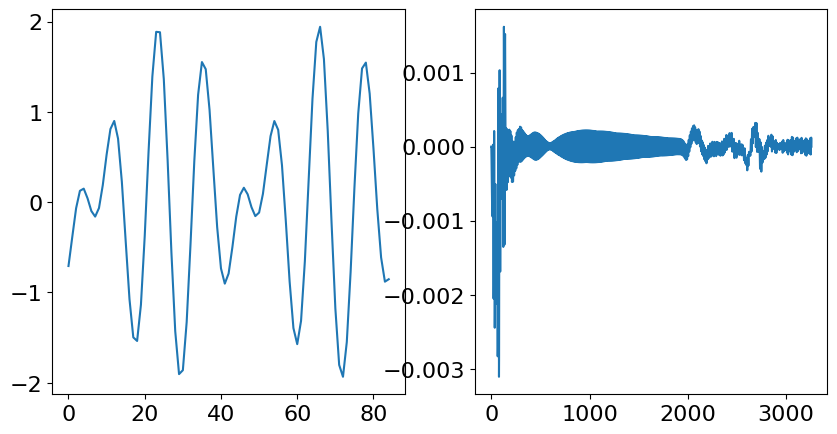

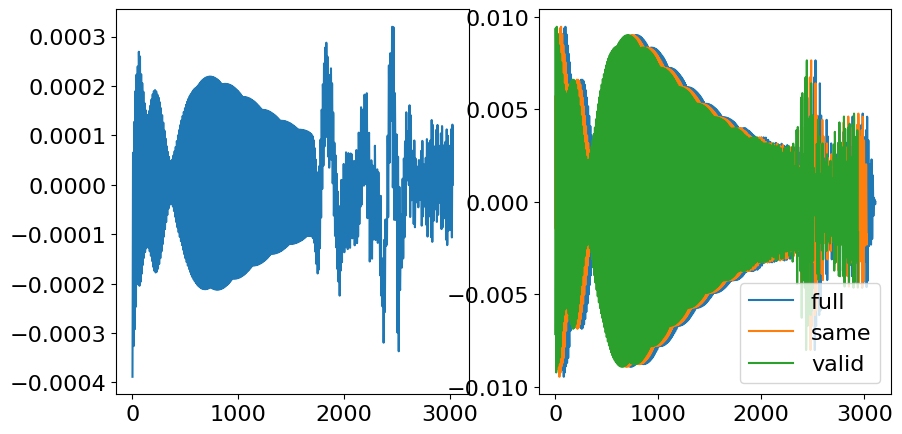

Peak: 163 
Peak full: 247 
Peak same: 205
Distance: 2.310524946078658 
Distance full: 3.5012249182909727 
Distance same: 2.9058749321848154


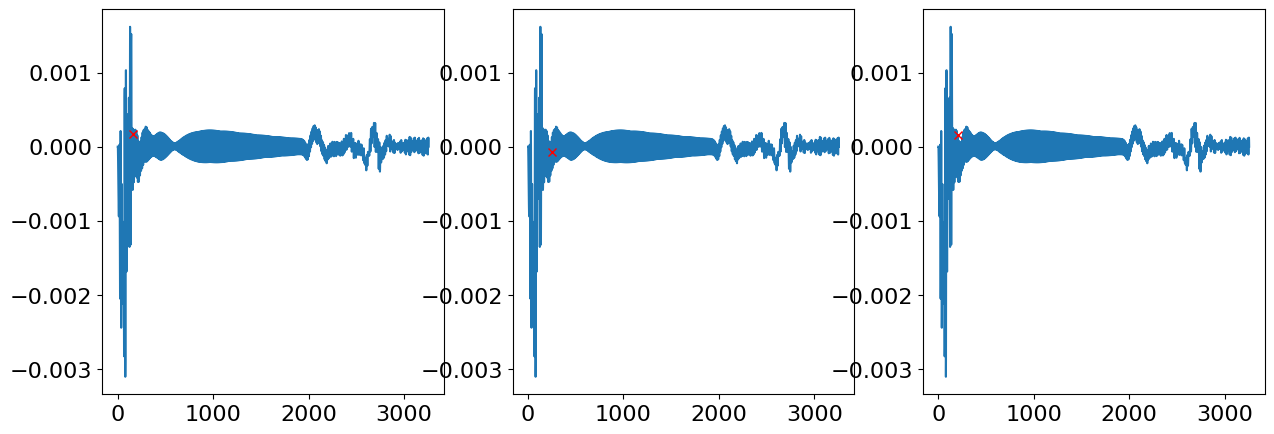

In [6]:
record = np.average(sonar.rec.data, axis=1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(ideal_signal)
ax[1].plot(record)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cut = 2 * ideal_signal.shape[0] + max_latency
print(f"Ideal signal length: {ideal_signal.shape[0]}")
print(f"Cutting at {cut} (max latency: {max_latency})")
ax[0].plot(record[cut:])
correlate = np.correlate(record[cut:], ideal_signal)
correlate_full = np.correlate(record[cut:], ideal_signal, mode="full")
correlate_same = np.correlate(record[cut:], ideal_signal, mode="same")
ax[1].plot(correlate_full, label="full")
ax[1].plot(correlate_same, label="same")
ax[1].plot(correlate, label="valid")
ax[1].legend()
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
peak = cut + correlate.argmax() - ideal_signal.shape[0]
peak_full = cut + correlate_full.argmax() - ideal_signal.shape[0]
peak_same = cut + correlate_same.argmax() - ideal_signal.shape[0]
print(f"Peak: {peak} \nPeak full: {peak_full} \nPeak same: {peak_same}")
ax[0].plot(record)
ax[0].plot(peak, record[peak], "rx")
ax[1].plot(record)
ax[1].plot(peak_full, record[peak_full], "rx")
ax[2].plot(record)
ax[2].plot(peak_same, record[peak_same], "rx")
distance = object_distance(peak, sonar.model.critical_dt, sonar.v_env)
distance_full = object_distance(peak_full, sonar.model.critical_dt, sonar.v_env)
distance_same = object_distance(peak_same, sonar.model.critical_dt, sonar.v_env)
print(f"Distance: {distance} \nDistance full: {distance_full} \nDistance same: {distance_same}")


8x cut

Ideal signal length: 85
Cutting at 743 (max latency: 63)


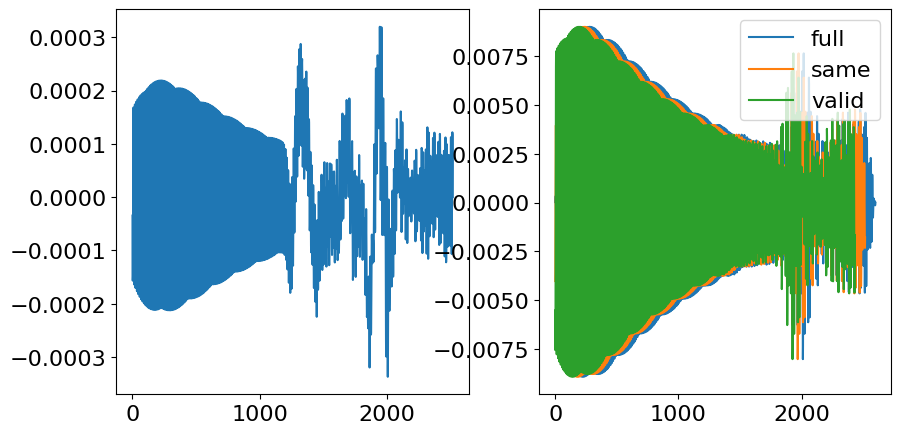

Peak: 851 
Peak full: 935 
Peak same: 893
Distance: 12.062924718484282 
Distance full: 13.253624690696597 
Distance same: 12.65827470459044


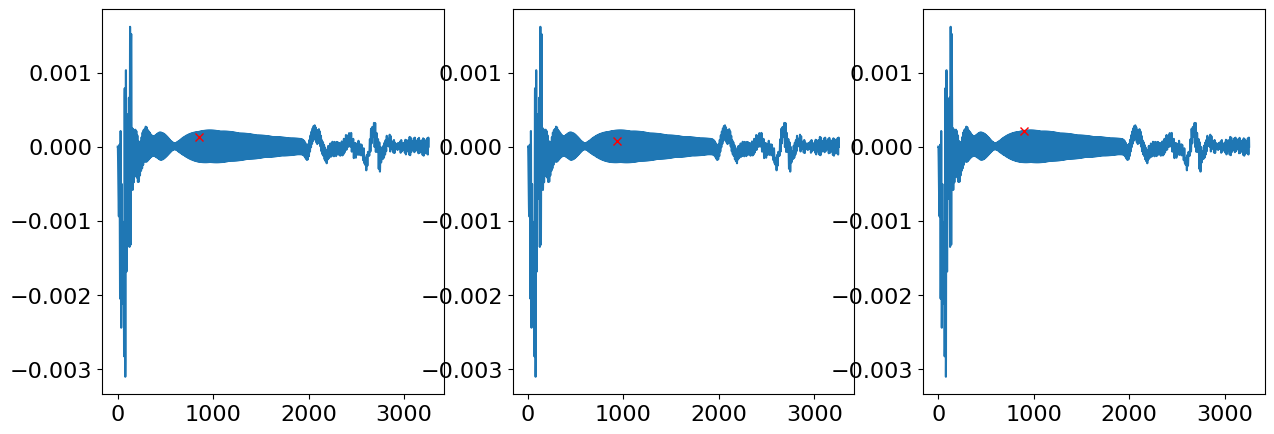

In [7]:
record = np.average(sonar.rec.data, axis=1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cut = 8 * ideal_signal.shape[0] + max_latency
print(f"Ideal signal length: {ideal_signal.shape[0]}")
print(f"Cutting at {cut} (max latency: {max_latency})")
ax[0].plot(record[cut:])
correlate = np.correlate(record[cut:], ideal_signal)
correlate_full = np.correlate(record[cut:], ideal_signal, mode="full")
correlate_same = np.correlate(record[cut:], ideal_signal, mode="same")
ax[1].plot(correlate_full, label="full")
ax[1].plot(correlate_same, label="same")
ax[1].plot(correlate, label="valid")
ax[1].legend()
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
peak = cut + correlate.argmax() - ideal_signal.shape[0]
peak_full = cut + correlate_full.argmax() - ideal_signal.shape[0]
peak_same = cut + correlate_same.argmax() - ideal_signal.shape[0]
print(f"Peak: {peak} \nPeak full: {peak_full} \nPeak same: {peak_same}")
ax[0].plot(record)
ax[0].plot(peak, record[peak], "rx")
ax[1].plot(record)
ax[1].plot(peak_full, record[peak_full], "rx")
ax[2].plot(record)
ax[2].plot(peak_same, record[peak_same], "rx")
distance = object_distance(peak, sonar.model.critical_dt, sonar.v_env)
distance_full = object_distance(peak_full, sonar.model.critical_dt, sonar.v_env)
distance_same = object_distance(peak_same, sonar.model.critical_dt, sonar.v_env)
print(f"Distance: {distance} \nDistance full: {distance_full} \nDistance same: {distance_same}")

16x cut

Ideal signal length: 85
Cutting at 1423 (max latency: 63)


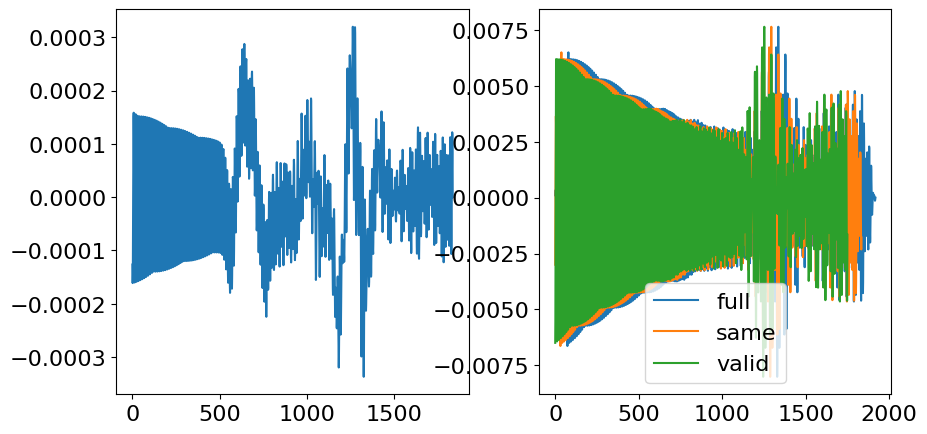

Peak: 2591 
Peak full: 2675 
Peak same: 2633
Distance: 36.72742414288223 
Distance full: 37.91812411509454 
Distance same: 37.322774128988385


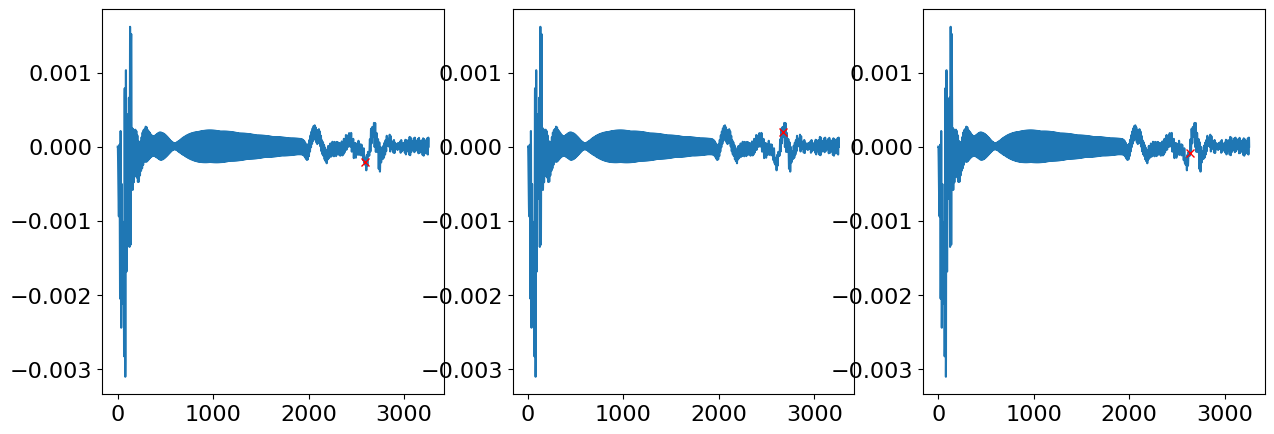

In [8]:
record = np.average(sonar.rec.data, axis=1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cut = 16 * ideal_signal.shape[0] + max_latency
print(f"Ideal signal length: {ideal_signal.shape[0]}")
print(f"Cutting at {cut} (max latency: {max_latency})")
ax[0].plot(record[cut:])
correlate = np.correlate(record[cut:], ideal_signal)
correlate_full = np.correlate(record[cut:], ideal_signal, mode="full")
correlate_same = np.correlate(record[cut:], ideal_signal, mode="same")
ax[1].plot(correlate_full, label="full")
ax[1].plot(correlate_same, label="same")
ax[1].plot(correlate, label="valid")
ax[1].legend()
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
peak = cut + correlate.argmax() - ideal_signal.shape[0]
peak_full = cut + correlate_full.argmax() - ideal_signal.shape[0]
peak_same = cut + correlate_same.argmax() - ideal_signal.shape[0]
print(f"Peak: {peak} \nPeak full: {peak_full} \nPeak same: {peak_same}")
ax[0].plot(record)
ax[0].plot(peak, record[peak], "rx")
ax[1].plot(record)
ax[1].plot(peak_full, record[peak_full], "rx")
ax[2].plot(record)
ax[2].plot(peak_same, record[peak_same], "rx")
distance = object_distance(peak, sonar.model.critical_dt, sonar.v_env)
distance_full = object_distance(peak_full, sonar.model.critical_dt, sonar.v_env)
distance_same = object_distance(peak_same, sonar.model.critical_dt, sonar.v_env)
print(f"Distance: {distance} \nDistance full: {distance_full} \nDistance same: {distance_same}")


Normalized correlation

Ideal signal length: 85
Cutting at 233 (max latency: 63)


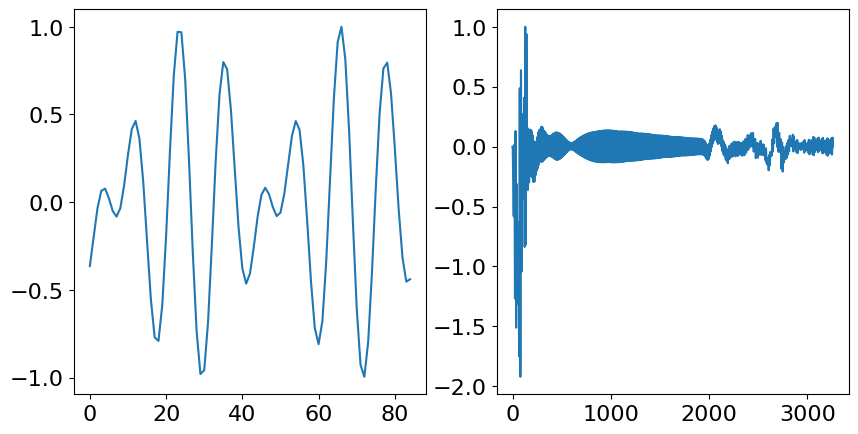

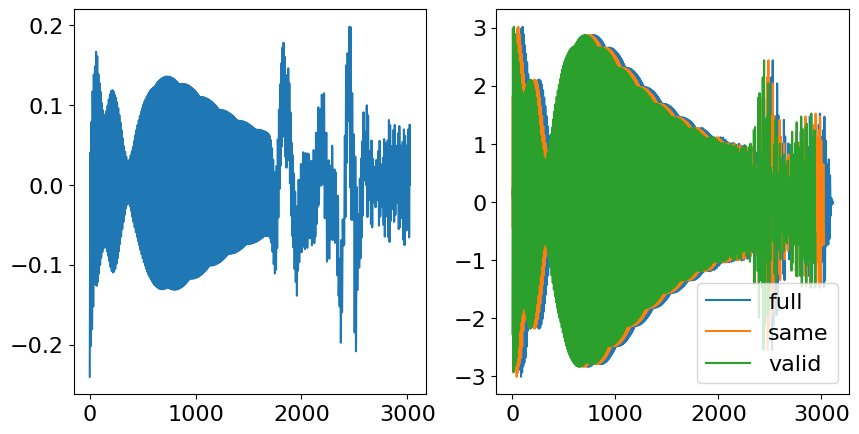

Peak: 163 
Peak full: 247 
Peak same: 205
Distance: 2.310524946078658 
Distance full: 3.5012249182909727 
Distance same: 2.9058749321848154


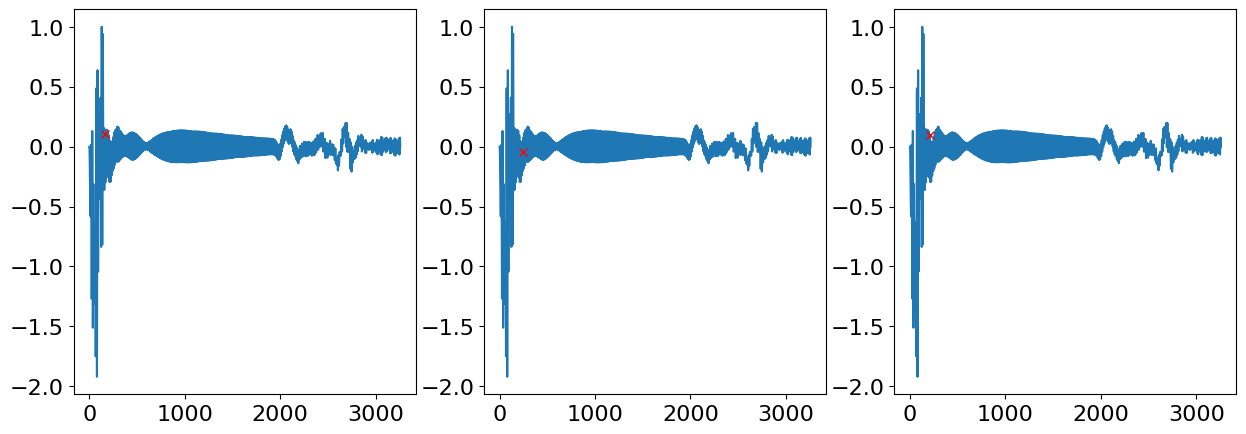

In [9]:
record = np.average(sonar.rec.data, axis=1)
record = record / np.max(record)
ideal_signal = ideal_signal / np.max(ideal_signal)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(ideal_signal)
ax[1].plot(record)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cut = 2 * ideal_signal.shape[0] + max_latency
print(f"Ideal signal length: {ideal_signal.shape[0]}")
print(f"Cutting at {cut} (max latency: {max_latency})")
ax[0].plot(record[cut:])
correlate = np.correlate(record[cut:], ideal_signal)
correlate_full = np.correlate(record[cut:], ideal_signal, mode="full")
correlate_same = np.correlate(record[cut:], ideal_signal, mode="same")
ax[1].plot(correlate_full, label="full")
ax[1].plot(correlate_same, label="same")
ax[1].plot(correlate, label="valid")
ax[1].legend()
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
peak = cut + correlate.argmax() - ideal_signal.shape[0]
peak_full = cut + correlate_full.argmax() - ideal_signal.shape[0]
peak_same = cut + correlate_same.argmax() - ideal_signal.shape[0]
print(f"Peak: {peak} \nPeak full: {peak_full} \nPeak same: {peak_same}")
ax[0].plot(record)
ax[0].plot(peak, record[peak], "rx")
ax[1].plot(record)
ax[1].plot(peak_full, record[peak_full], "rx")
ax[2].plot(record)
ax[2].plot(peak_same, record[peak_same], "rx")
distance = object_distance(peak, sonar.model.critical_dt, sonar.v_env)
distance_full = object_distance(peak_full, sonar.model.critical_dt, sonar.v_env)
distance_same = object_distance(peak_same, sonar.model.critical_dt, sonar.v_env)
print(f"Distance: {distance} \nDistance full: {distance_full} \nDistance same: {distance_same}")


Bandpass filter

Sampling frequency: 52.91005414482904
Peak: 1878 
Peak full: 1962 
Peak same: 1920
Distance: 26.620649378746748 
Distance full: 27.811349350959063 
Distance same: 27.215999364852905


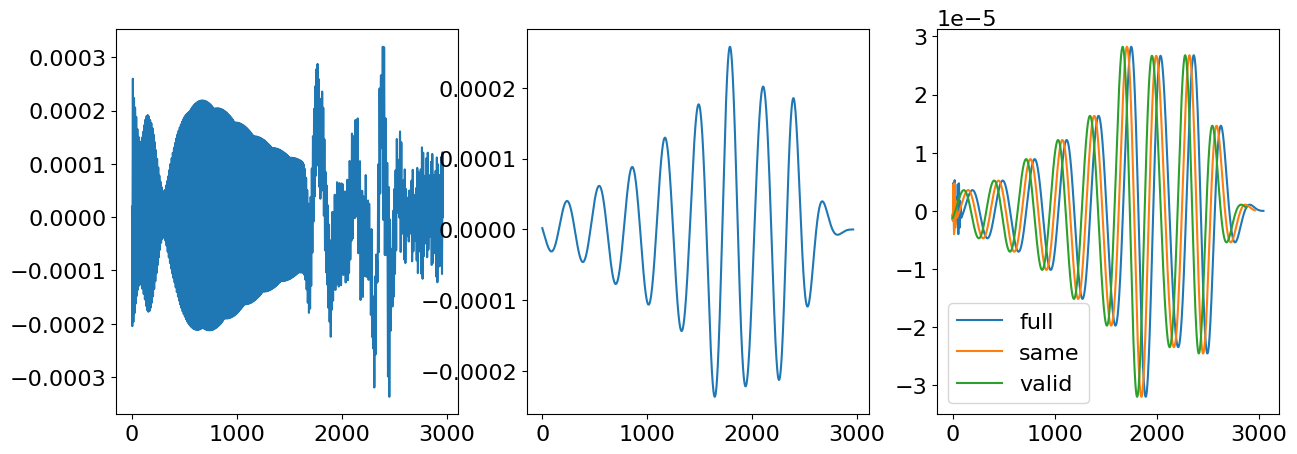

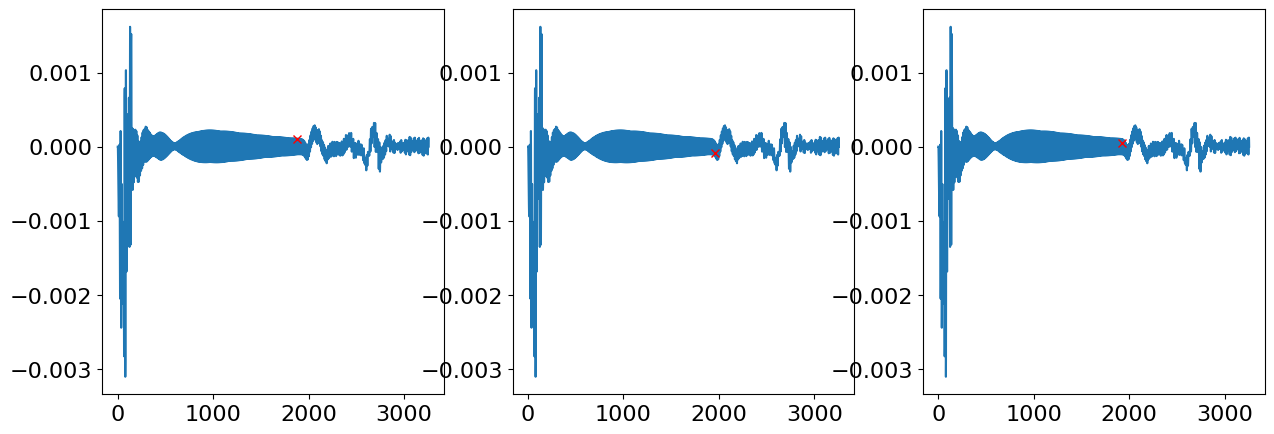

In [10]:
record = np.average(sonar.rec.data, axis=1)
fs = 1 / sonar.model.critical_dt
print(f"Sampling frequency: {fs}")
lowcut = f0 - 2
highcut = f0 + 2
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
order = 4
cut = 2 * (ideal_signal.shape[0] + max_latency)
b, a = signal.butter(order, [low, high], btype="bandpass", fs=fs)
filtered = signal.filtfilt(b, a, record[cut:])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
correlate = np.correlate(filtered, ideal_signal)
correlate_full = np.correlate(filtered, ideal_signal, mode="full")
correlate_same = np.correlate(filtered, ideal_signal, mode="same")
ax[0].plot(record[cut:])
ax[1].plot(filtered)
ax[2].plot(correlate_full, label="full")
ax[2].plot(correlate_same, label="same")
ax[2].plot(correlate, label="valid")
ax[2].legend()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
peak = cut + correlate.argmax() - ideal_signal.shape[0]
peak_full = cut + correlate_full.argmax() - ideal_signal.shape[0]
peak_same = cut + correlate_same.argmax() - ideal_signal.shape[0]
print(f"Peak: {peak} \nPeak full: {peak_full} \nPeak same: {peak_same}")
ax[0].plot(record)
ax[0].plot(peak, record[peak], "rx")
ax[1].plot(record)
ax[1].plot(peak_full, record[peak_full], "rx")
ax[2].plot(record)
ax[2].plot(peak_same, record[peak_same], "rx")
distance = object_distance(peak, sonar.model.critical_dt, sonar.v_env)
distance_full = object_distance(peak_full, sonar.model.critical_dt, sonar.v_env)
distance_same = object_distance(peak_same, sonar.model.critical_dt, sonar.v_env)
print(f"Distance: {distance} \nDistance full: {distance_full} \nDistance same: {distance_same}")

Sampling frequency: 52.91005414482904
Peak: 874 
Peak full: 958 
Peak same: 916
Distance: 12.38894971087575 
Distance full: 13.579649683088064 
Distance same: 12.984299696981907


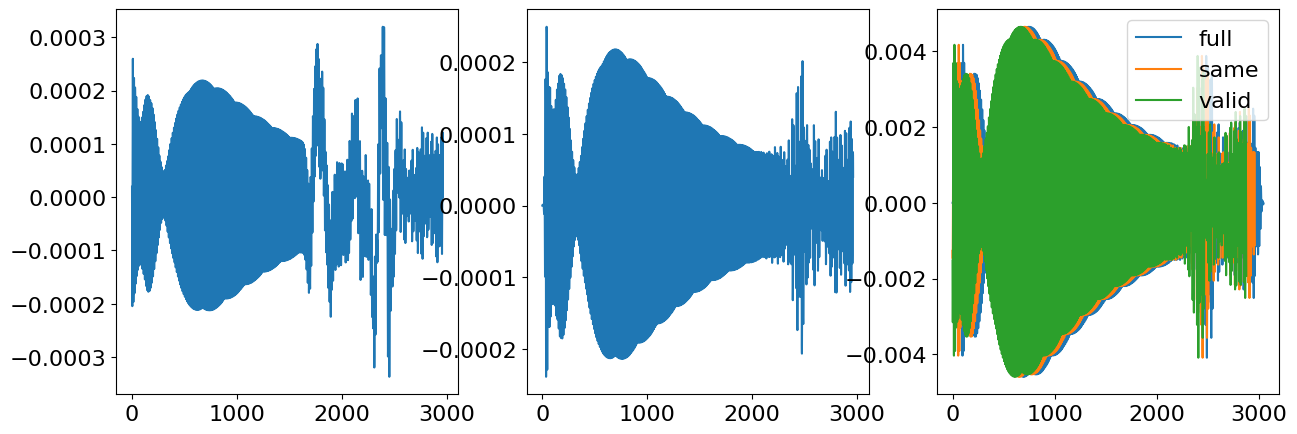

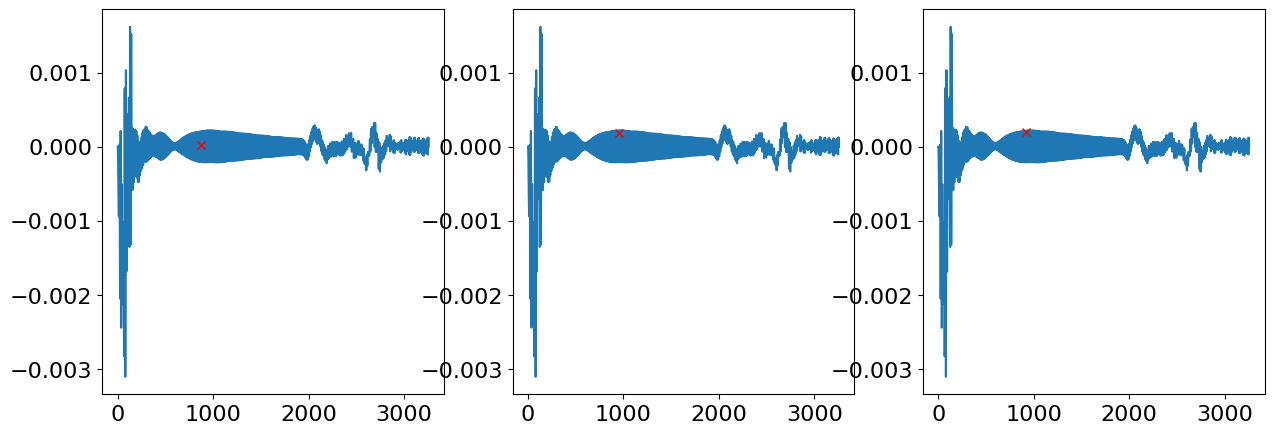

In [11]:
record = np.average(sonar.rec.data, axis=1)
print(f"Sampling frequency: {1 / sonar.model.critical_dt}")
cut = 2 * (ideal_signal.shape[0] + max_latency)
bandpass = signal.butter(10, [f0 - 2, f0 + 2], btype="bandpass", fs=1 / sonar.model.critical_dt, output="sos")
filtered = signal.sosfilt(bandpass, record[cut:])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
correlate = np.correlate(filtered, ideal_signal)
correlate_full = np.correlate(filtered, ideal_signal, mode="full")
correlate_same = np.correlate(filtered, ideal_signal, mode="same")
ax[0].plot(record[cut:])
ax[1].plot(filtered)
ax[2].plot(correlate_full, label="full")
ax[2].plot(correlate_same, label="same")
ax[2].plot(correlate, label="valid")
ax[2].legend()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
peak = cut + correlate.argmax() - ideal_signal.shape[0]
peak_full = cut + correlate_full.argmax() - ideal_signal.shape[0]
peak_same = cut + correlate_same.argmax() - ideal_signal.shape[0]
print(f"Peak: {peak} \nPeak full: {peak_full} \nPeak same: {peak_same}")
ax[0].plot(record)
ax[0].plot(peak, record[peak], "rx")
ax[1].plot(record)
ax[1].plot(peak_full, record[peak_full], "rx")
ax[2].plot(record)
ax[2].plot(peak_same, record[peak_same], "rx")
distance = object_distance(peak, sonar.model.critical_dt, sonar.v_env)
distance_full = object_distance(peak_full, sonar.model.critical_dt, sonar.v_env)
distance_same = object_distance(peak_same, sonar.model.critical_dt, sonar.v_env)
print(f"Distance: {distance} \nDistance full: {distance_full} \nDistance same: {distance_same}")

Use Nyquist frequency to normalize the correlation

Sampling frequency: 52.91005414482904
Peak: 2804 
Peak full: 3237 
Peak same: 3141
Distance: 39.7466990724206 
Distance full: 45.884473929181695 
Distance same: 44.52367396093905


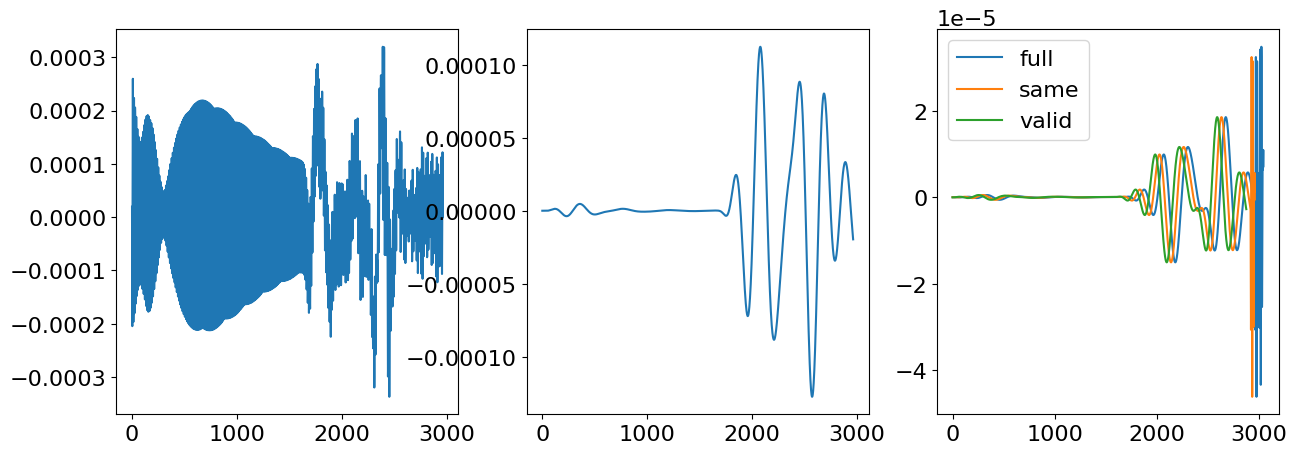

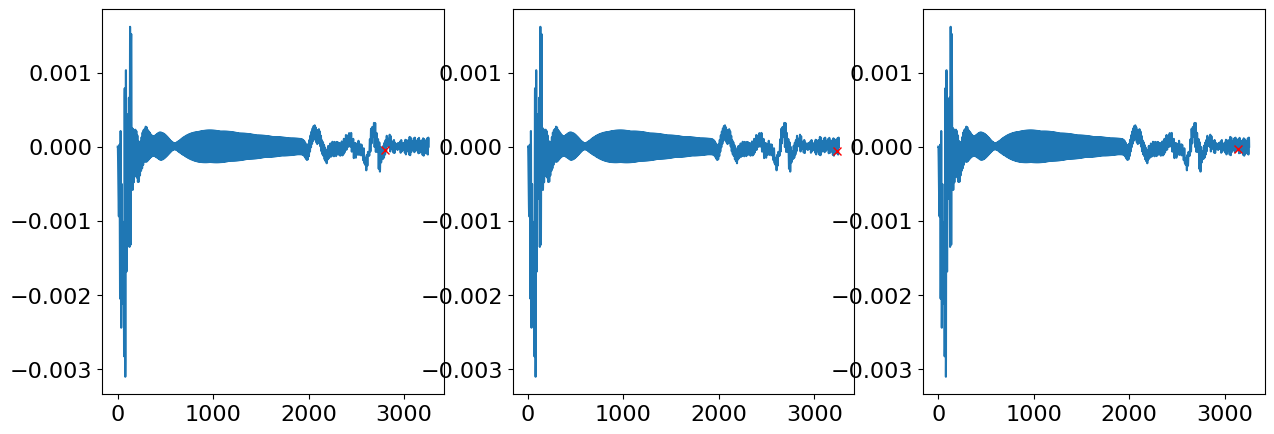

In [12]:
record = np.average(sonar.rec.data, axis=1)
fs = 1 / sonar.model.critical_dt
print(f"Sampling frequency: {fs}")
cut = 2 * (ideal_signal.shape[0] + max_latency)
fs = 1 / sonar.model.critical_dt
lowcut = f0 - 2
highcut = f0 + 2
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
order = 4
bandpass = signal.butter(4, [low, high], btype="bandpass", fs=1 / sonar.model.critical_dt, output="sos")
filtered = signal.sosfilt(bandpass, record[cut:])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
correlate = np.correlate(filtered, ideal_signal)
correlate_full = np.correlate(filtered, ideal_signal, mode="full")
correlate_same = np.correlate(filtered, ideal_signal, mode="same")
ax[0].plot(record[cut:])
ax[1].plot(filtered)
ax[2].plot(correlate_full, label="full")
ax[2].plot(correlate_same, label="same")
ax[2].plot(correlate, label="valid")
ax[2].legend()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
peak = cut + correlate.argmax() - ideal_signal.shape[0]
peak_full = cut + correlate_full.argmax() - ideal_signal.shape[0]
peak_same = cut + correlate_same.argmax() - ideal_signal.shape[0]
print(f"Peak: {peak} \nPeak full: {peak_full} \nPeak same: {peak_same}")
ax[0].plot(record)
ax[0].plot(peak, record[peak], "rx")
ax[1].plot(record)
ax[1].plot(peak_full, record[peak_full], "rx")
ax[2].plot(record)
ax[2].plot(peak_same, record[peak_same], "rx")
distance = object_distance(peak, sonar.model.critical_dt, sonar.v_env)
distance_full = object_distance(peak_full, sonar.model.critical_dt, sonar.v_env)
distance_same = object_distance(peak_same, sonar.model.critical_dt, sonar.v_env)
print(f"Distance: {distance} \nDistance full: {distance_full} \nDistance same: {distance_same}")